In [35]:
import numpy as np
from scipy.linalg import sqrtm
from scipy.special import softmax
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from IPython.display import HTML

In [36]:
def draw_kkl(nx_G, label_map, node_color, pos=None, **kwargs):
    fig, ax = plt.subplots(figsize=(10, 10))
    if pos is None:
        pos = nx.spring_layout(nx_G, k=5/np.sqrt(nx_G.number_of_nodes()))
        
    nx.draw(
        nx_G, pos, with_labels=label_map is not None,
        labels=label_map,
        node_color=node_color,
        ax=ax, **kwargs)

# Zachary's Karate Club

In [37]:
g = nx.karate_club_graph()

In [38]:
g.number_of_nodes(), g.number_of_edges()

(34, 78)

In [39]:
communities = greedy_modularity_communities(g)

In [40]:
colors = np.zeros(g.number_of_nodes())
for i, com in enumerate(communities):
    colors[list(com)] = i

n_classes = np.unique(colors).shape[0]
labels = np.eye(n_classes)[colors.astype(int)]

In [41]:
club_labels = nx.get_node_attributes(g, 'club')

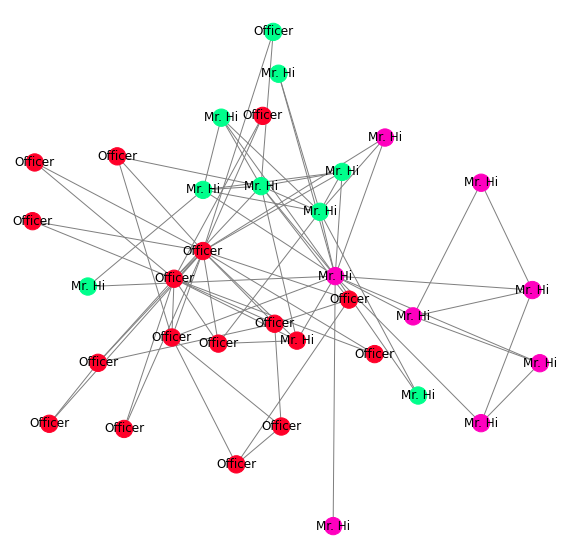

In [42]:
_ = draw_kkl(g, club_labels, colors, cmap='gist_rainbow', edge_color='gray')

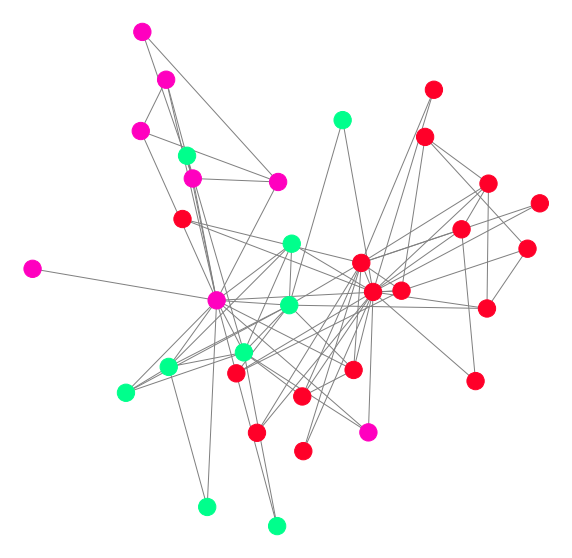

In [43]:
_ = draw_kkl(g, None, colors, cmap='gist_rainbow', edge_color='gray')

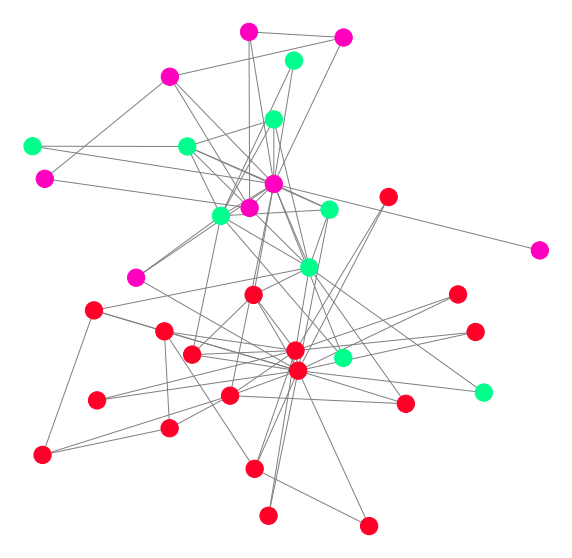

In [44]:
fig, ax = plt.subplots(figsize=(10, 10))
pos = nx.spring_layout(g, k=5/np.sqrt(g.number_of_nodes()))
kwargs = {"cmap": 'gist_rainbow', "edge_color": 'gray'}
nx.draw(
    g, pos, with_labels=False,
    node_color=colors,
    ax=ax, **kwargs)
#plt.savefig('karate_club_graph.png', bbox_inches='tight', transparent=True)

In [45]:
A = nx.to_numpy_matrix(g)
A

matrix([[0., 1., 1., ..., 1., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 1.],
        [0., 0., 1., ..., 1., 0., 1.],
        [0., 0., 0., ..., 1., 1., 0.]])

In [46]:
A_mod = A + np.eye(g.number_of_nodes())  # add self-connections

D_mod = np.zeros_like(A_mod)
np.fill_diagonal(D_mod, np.asarray(A_mod.sum(axis=1)).flatten())

D_mod_invroot = np.linalg.inv(sqrtm(D_mod))

A_hat = D_mod_invroot @ A_mod @ D_mod_invroot

In [47]:
X = np.eye(g.number_of_nodes())

### Great resource for handling matrices/vectors/dots/transposes when deriving gradient equations:  [Stanford CS224n Gradient Notes](https://web.stanford.edu/class/cs224n/readings/gradient-notes.pdf)

In [48]:
def glorot_init(nin, nout):
    sd = np.sqrt(6.0 / (nin + nout))
    return np.random.uniform(-sd, sd, size=(nin, nout))

def xent(pred, labels):
    return -np.log(pred)[np.arange(pred.shape[0]), np.argmax(labels, axis=1)]

def norm_diff(dW, dW_approx):
    return np.linalg.norm(dW - dW_approx) / (np.linalg.norm(dW) + np.linalg.norm(dW_approx))


class GradDescentOptim():
    
    def __init__(self, lr, wd):
        self.lr = lr
        self.wd = wd
        self._y_pred = None
        self._y_true = None
        self.out = None
        self.bs = None
        self.train_nodes = None
    
    def __call__(self, y_pred, y_true, train_nodes=None):
        self.y_pred = y_pred
        self.y_true = y_true
        
        if train_nodes is None:
            self.train_nodes = np.arange(y_pred.shape[0])
        else:
            self.train_nodes = train_nodes
            
        self.bs = self.train_nodes.shape[0]
        
    
    @property
    def out(self):
        return self._out
    
    @out.setter
    def out(self, y):
        self._out = y
    

class GCNLayer():
    
    def __init__(self, n_inputs, n_outputs, activation=None, name=''):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.activation = activation
        self.name = name
        
    def __repr__(self):
        return f"GCN: W{'_' + self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"
    
    def forward(self, A, X, W=None):
        """
        Assumes A is (bs, bs) adjacency matrix and X is (bs, D),
            where bs = "batch size" and D = input feature length
        """
        self._X = (A @ X).T  # for calculating gradients.  (D, bs)
        
        if W is None:
            W = self.W
            
        H = W @ self._X  # (h, D)*(D, bs) -> (h, bs)
        if self.activation is not None:
            H = self.activation(H)
        self._H = H  # (h, bs)
        return self._H.T  # (bs, h)
    
    def backward(self, optim, update=True):
        dtanh = 1 - np.asarray(self._H.T)**2  # (bs, out_dim)
        d2 = np.multiply(optim.out, dtanh)  # (bs, out_dim) *element_wise* (bs, out_dim)
        
        optim.out = d2 @ self.W  # (bs, out_dim)*(out_dim, in_dim) = (bs, in_dim)
        
        dW = np.asarray(d2.T @ self._X.T) / optim.bs  # (out_dim, bs)*(bs, D) -> (out_dim, D)
        dW_wd = self.W * optim.wd / optim.bs  # weight decay update
        
        if update:
            self.W -= (dW + dW_wd) * optim.lr
            
        return dW + dW_wd
    
    
class SoftmaxLayer():
    
    def __init__(self, n_inputs, n_outputs, name=''):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.b = np.zeros((self.n_outputs, 1))
        self.name = name
        self._X = None # Used to calculate gradients
        
    def __repr__(self):
        return f"Softmax: W{'_' + self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"

    def shift(self, proj):
        shiftx = proj - np.max(proj, axis=0, keepdims=True)
        exps = np.exp(shiftx)
        return exps / np.sum(exps, axis=0, keepdims=True)
    
    def forward(self, X, W=None, b=None):
        """Compute the sofrmax of vector x in a numerically stable way.
        
        X is assumed to be (bs, h)
        """
        self._X = X.T
        if W is None:
            W = self.W
        if b is None:
            b = self.b
            
        proj = np.asarray(W @ self._X) + b  # (out, h)*(h, bs) = (out, bs)
        return self.shift(proj).T  # (bs, out)
    
    def backward(self, optim, update=True):
        # should take in optimizer, update its own parameters and update the optimizer's "out"
        # Build mask on loss
        train_mask = np.zeros(optim.y_pred.shape[0])
        train_mask[optim.train_nodes] = 1
        train_mask = train_mask.reshape((-1, 1))
        
        # derivative of loss w.r.t. activation (pre-softmax)
        d1 = np.asarray((optim.y_pred - optim.y_true))  # (bs, out_dim)
        d1 = np.multiply(d1, train_mask)  # (bs, out_dim) with loss of not-train nodes set to zero
        
        optim.out = d1 @ self.W  # (bs, out_dim)*(out_dim, in_dim) = (bs, in_dim)
        
        dW = (d1.T @ self._X.T) / optim.bs  # (out_dim, bs)*(bs, in_dim) -> (out_dim, in_dim)
        db = d1.T.sum(axis=1, keepdims=True) / optim.bs  # (out_dim, 1)
        
        dW_wd = self.W * optim.wd / optim.bs  # weight decay update
        
        if update:
            self.W -= (dW + dW_wd) * optim.lr
            self.b -= db.reshape(self.b.shape) * optim.lr
        
        return dW + dW_wd, db.reshape(self.b.shape)

In [49]:
gcn1 = GCNLayer(g.number_of_nodes(), 2, activation=np.tanh, name='1')
sm1 = SoftmaxLayer(2, n_classes, "SM")
opt = GradDescentOptim(lr=0, wd=1.)

In [50]:
gcn1_out = gcn1.forward(A_hat, X)
opt(sm1.forward(gcn1_out), labels)

## Gradient checking on Softmax layer

In [51]:
def get_grads(inputs, layer, argname, labels, eps=1e-4, wd=0):
    cp = getattr(layer, argname).copy()
    cp_flat = np.asarray(cp).flatten()
    grads = np.zeros_like(cp_flat)
    n_parms = cp_flat.shape[0]
    for i, theta in enumerate(cp_flat):
        #print(f"Parm {argname}_{i}")
        theta_cp = theta
        
        # J(theta + eps)
        cp_flat[i] = theta + eps
        cp_tmp = cp_flat.reshape(cp.shape)
        predp = layer.forward(*inputs, **{argname: cp_tmp})
        wd_term = wd/2*(cp_flat**2).sum() / labels.shape[0]
        #print(wd_term)
        Jp = xent(predp, labels).mean() + wd_term
        
        # J(theta - eps)
        cp_flat[i] = theta - eps
        cp_tmp = cp_flat.reshape(cp.shape)
        predm = layer.forward(*inputs, **{argname: cp_tmp})
        wd_term = wd/2*(cp_flat**2).sum() / labels.shape[0]
        #print(wd_term)
        Jp = xent(predp, labels).mean() + wd_term
        
        # J(theta - eps)
        cp_flat[i] = theta - eps
        cp_tmp = cp_flat.reshape(cp.shape)
        predm = layer.forward(*inputs, **{argname: cp_tmp})
        wd_term = wd/2*(cp_flat**2).sum() / labels.shape[0]
        #print(wd_term)
        Jm = xent(predm, labels).mean() + wd_term
        
        # grad
        grads[i] = ((Jp - Jm) / (2*eps))
        
        # Back to normal
        cp_flat[i] = theta
    
    return grads.reshape(cp.shape)

In [52]:
dW_approx = get_grads((gcn1_out,), sm1, "W", labels, eps=1e-4, wd=opt.wd)
db_approx = get_grads((gcn1_out,), sm1, "b", labels, eps=1e-4, wd=opt.wd)

In [53]:
gcn1_out = gcn1.forward(A_hat, X)
opt(sm1.forward(gcn1_out), labels)

## Gradient checking on Softmax layer

In [54]:
def get_grads(inputs, layer, argname, labels, eps=1e-4, wd=0):
    cp = getattr(layer, argname).copy()
    cp_flat = np.asarray(cp).flatten()
    grads = np.zeros_like(cp_flat)
    n_parms = cp_flat.shape[0]
    for i, theta in enumerate(cp_flat):
        #print(f"Parm {argname}_{i}")
        theta_cp = theta
        
        # J(theta + eps)
        cp_flat[i] = theta + eps
        cp_tmp = cp_flat.reshape(cp.shape)
        predp = layer.forward(*inputs, **{argname: cp_tmp})
        wd_term = wd/2*(cp_flat**2).sum() / labels.shape[0]
        #print(wd_term)
        Jp = xent(predp, labels).mean() + wd_term
        
        # J(theta - eps)
        cp_flat[i] = theta - eps
        cp_tmp = cp_flat.reshape(cp.shape)
        predm = layer.forward(*inputs, **{argname: cp_tmp})
        wd_term = wd/2*(cp_flat**2).sum() / labels.shape[0]
        #print(wd_term)
        Jm = xent(predm, labels).mean() + wd_term
        
        # grad
        grads[i] = ((Jp - Jm) / (2*eps))
        
        # Back to normal
        cp_flat[i] = theta
        
    return grads.reshape(cp.shape)

In [55]:
dW_approx = get_grads((gcn1_out,), sm1, "W", labels, eps=1e-4, wd=opt.wd)
db_approx = get_grads((gcn1_out,), sm1, "b", labels, eps=1e-4, wd=opt.wd)

In [56]:
dW, db = sm1.backward(opt, update=False)

In [57]:
assert norm_diff(dW, dW_approx) < 1e-7
assert norm_diff(db, db_approx) < 1e-7

## Gradient checking on GCN layer

In [58]:
def get_gcn_grads(inputs, gcn, sm_layer, labels, eps=1e-4, wd=0):
    cp = gcn.W.copy()
    cp_flat = np.asarray(cp).flatten()
    grads = np.zeros_like(cp_flat)
    n_parms = cp_flat.shape[0]
    for i, theta in enumerate(cp_flat):
        theta_cp = theta
        
        # J(theta + eps)
        cp_flat[i] = theta + eps
        cp_tmp = cp_flat.reshape(cp.shape)
        pred = sm_layer.forward(gcn.forward(*inputs, W=cp_tmp))
        w2 = (cp_flat**2).sum() + (sm_layer.W.flatten()**2).sum()
        Jp = xent(pred, labels).mean() + wd/(2*labels.shape[0])*w2
        
        # J(theta - eps)
        cp_flat[i] = theta - eps
        cp_tmp = cp_flat.reshape(cp.shape)
        pred = sm_layer.forward(gcn.forward(*inputs, W=cp_tmp))
        w2 = (cp_flat**2).sum() + (sm_layer.W.flatten()**2).sum()
        Jp = xent(pred, labels).mean() + wd/(2*labels.shape[0])*w2
        
        # J(theta - eps)
        cp_flat[i] = theta - eps
        cp_tmp = cp_flat.reshape(cp.shape)
        pred = sm_layer.forward(gcn.forward(*inputs, W=cp_tmp))
        w2 = (cp_flat**2).sum() + (sm_layer.W.flatten()**2).sum()
        Jm = xent(pred, labels).mean() + wd/(2*labels.shape[0])*w2
        
        # grad
        grads[i] = ((Jp - Jm) / (2*eps))
        
        # Back to normal
        cp_flat[i] = theta
    
    return grads.reshape(cp.shape)

In [59]:
dW2 = gcn1.backward(opt, update=False)

In [60]:
dW2_approx = get_gcn_grads((A_hat, X), gcn1, sm1, labels, eps=1e-4, wd=opt.wd)

In [ ]:
assert norm_diff(dW2, dW2_approx) < 1e-7

# The Model

In [ ]:
class GCNNetwork():
    
    def __init__(self, n_inputs, n_outputs, n_layers, )